### Usando o modelo CLIP treinado

O modelo CLIP pode ser usado em inúmeras tarefas nas quais *ele não foi treinado*. Isso porque ele não aprendeu nenhuma tarefa em específico (classificação, segmentação, etc). O modelo foi treinado apenas para extrair a similaridade entre imagens e textos. Portanto, se quisermos por exemplo realizar a classificação de uma imagem nas classes "gato" e "cachorro", basta calcularmos a distância entre a imagem e a codificação das palavras "gato" e "cachorro". 

Veremos abaixo uma outra aplicação interessante. Primeiro, utilizaremos o modelo para codificar todas as imagens do conjunto de validação. Na sequência, dado um prompt de texto o modelo retornará as K imagens mais similares ao prompt. 

In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from dataset import get_dataset, collate_fn, unormalize
from model import get_model

class ImageQuery:
    """Retorna imagens similares a um determinado prompt de texto."""

    def __init__(self, ds, model, device='cpu'):
        """
        Args:
            ds: dataset
            model: modelo CLIP
            device: CPU/CUDA.
        """

        self.ds = ds
        self.model = model
        self.device = device
        self.projections = None

    def create_projections(self):
        """Codifica todas as imagens do junto de validação."""

        dl = DataLoader(self.ds, batch_size=512, shuffle=False, collate_fn=collate_fn)

        model.eval()
        model.to(self.device)
        image_projections = torch.zeros((len(self.ds), 512), device=self.device)
        count = 0
        with torch.no_grad():
            for imgs, texts in dl:
                n = len(imgs)
                imgs = imgs.to(self.device)
                proj = model.project_images(imgs)
                image_projections[count:count+n] = proj
                count += n

        self.projections = image_projections

    def query(self, text, k=5):
        """Dado um prompt de texto, codifica o texto e retorna as k imagens
        mais similares."""

        text_embed = self.model.project_texts(text).squeeze()
        # Similaridade entre cada imagem e o texto codificado
        similarity = torch.matmul(self.projections, text_embed)
        # Índice das 5 imagens mais parecidas
        _, indices = torch.topk(similarity, k) 

        imgs = []
        for idx in indices:
            imgs.append(unormalize(self.ds[idx][0]))

        return imgs
    
    def plot_query(self, text):
        '''Mostra as imagens. Note que o método fixa o número de imagens em
        5 para simplificar.'''

        imgs = self.query(text)
        fig, axs = plt.subplots(1, 5, figsize=(15, 4))
        for idx in range(5):
            axs[idx].imshow(imgs[idx])


In [10]:
%%time
checkpoint = torch.load('../data/checkpoints/M10/checkpoint.pt')
model = get_model()
model.load_state_dict(checkpoint['model'])
ds_train, ds_valid = get_dataset('../data/oxford_pets', '../data/oxford_pets_captions.txt')
image_query = ImageQuery(ds_valid, model, 'cuda')

# A execução na CPU demora bastante. Se não tiver GPU, é possível ler as projeções
# armazenadas
image_query.create_projections()
#image_query.projections = torch.load('../data/checkpoints/M10/clip_projections.pt')

CPU times: total: 2.75 s
Wall time: 1.87 s


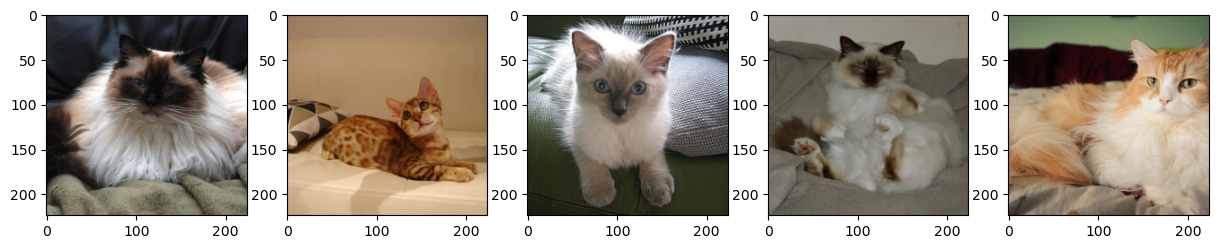

In [12]:
image_query.plot_query('a cat on a couch')

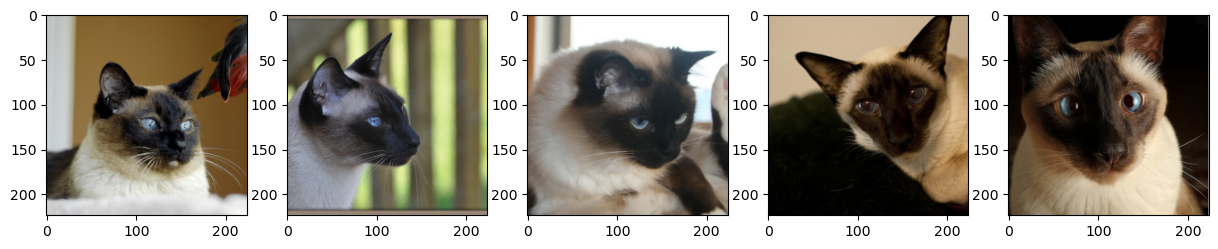

In [13]:
image_query.plot_query('a siamese cat')

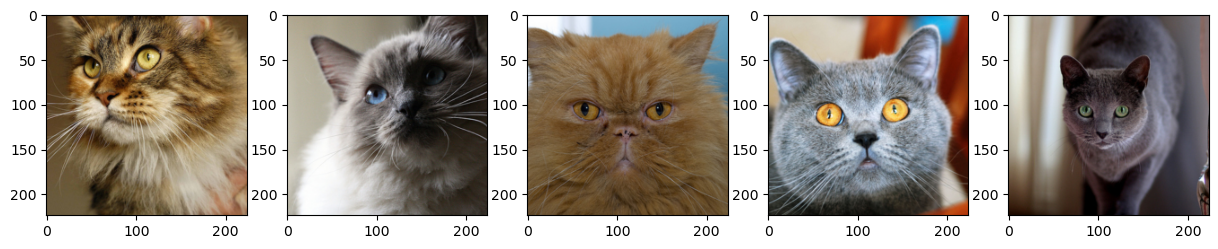

In [14]:
image_query.plot_query('a cat with yellow eyes')

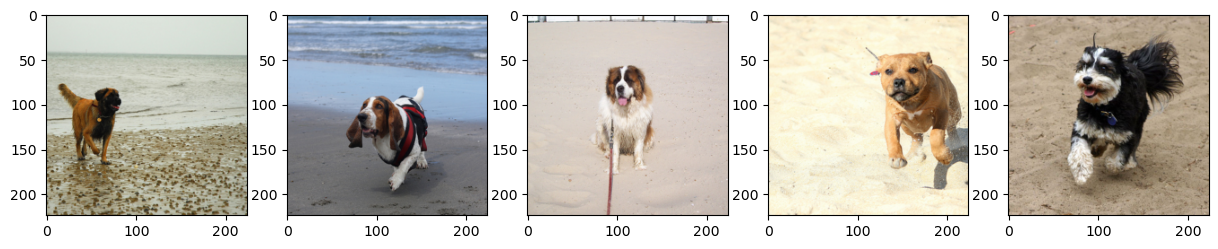

In [15]:
image_query.plot_query('a dog running on the beach')

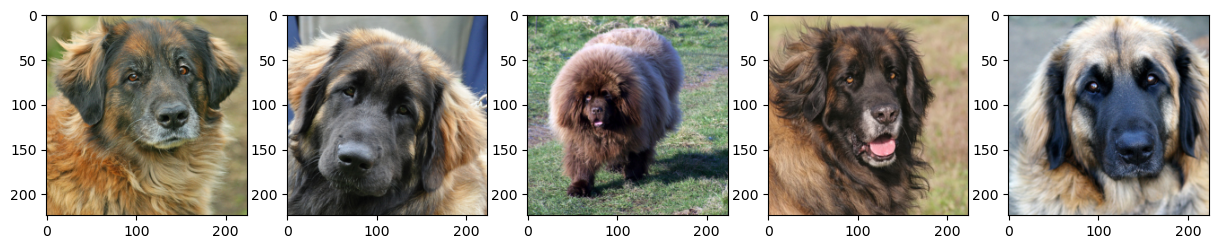

In [16]:
image_query.plot_query('a large dog')

Algumas palavras interessantes para usar no prompt:

* sitting, laying, standing
* white, black, gray
* yellow, blue eyes
* small, large
* collar, leash
* grass, green
* blanket
* pug, siamese, sphynx
* beach, water


### Modelo CLIP do Hugginface

A biblioteca Hugginface possui um modelo treinado em muito mais imagens que o nosso.

In [17]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
# Remoção das transformações, pois o modelo espera uma imagem pillow padrão
ds_valid.transform = None

# Lista com algumas imagens
imgs = [ds_valid[idx][0] for idx in range(6)]
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=imgs, 
                   return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)

# Probabilidade das imagens serem da classe gato:
logits_per_text = outputs.logits_per_text
probs_cat = logits_per_text.softmax(dim=0)[0]
print(probs_cat)

tensor([0.9975, 0.9970, 0.9985, 0.0043, 0.0026, 0.9988])


Podemos reimplementar a classe ImageQuery para um modelo do Hugginface

In [18]:
class ImageQuery:

    def __init__(self, ds, processor, model, device='cpu'):

        self.ds = ds
        self.processor = processor
        self.model = model
        self.device = device
        self.projections = None

    def create_projections(self):

        bs = 128
        ds = self.ds
        model = self.model
        device = self.device
        model.eval()
        model.to(device)

        ds_size = len(ds)
        # Número de batches
        num_batches = ds_size//bs + int(ds_size%bs!=0)
        image_projections = torch.zeros((ds_size, 768), device=device)
        count = 0
        for _ in range(num_batches):
            # n=bs ou o nro de imagens restantes
            n = min([bs, ds_size-count])
            # Cria um batch de imagens do pillow
            imgs = [ds[idx][0] for idx in range(count, count+n)]
            inputs = self.processor(images=imgs, return_tensors="pt")
            inputs = inputs.to(device)
            with torch.no_grad():
                proj = model.get_image_features(**inputs)
            image_projections[count:count+n] = proj
            count += n

        self.projections = image_projections

    def query(self, text):

        model = self.model
        model.eval()
        model.to(self.device)

        inputs = self.processor(text=text, return_tensors="pt")
        inputs = inputs.to(self.device)
        text_embed = model.get_text_features(**inputs)
        similarity = torch.matmul(self.projections, text_embed.squeeze())
        _, indices = torch.topk(similarity, 5) 

        imgs = []
        for idx in indices:
            imgs.append(self.ds[idx][0])

        return imgs
    
    def plot_query(self, text):

        imgs = self.query(text)
        fig, axs = plt.subplots(1, 5, figsize=(15, 4))
        for idx in range(5):
            axs[idx].imshow(imgs[idx])

image_query = ImageQuery(ds_valid, processor, model, 'cuda')
image_query.create_projections()
#image_query.projections = torch.load('data/clip_projections_hugginface.pt')
#torch.save(image_query.projections, 'data/clip_projections_hugginface.pt')

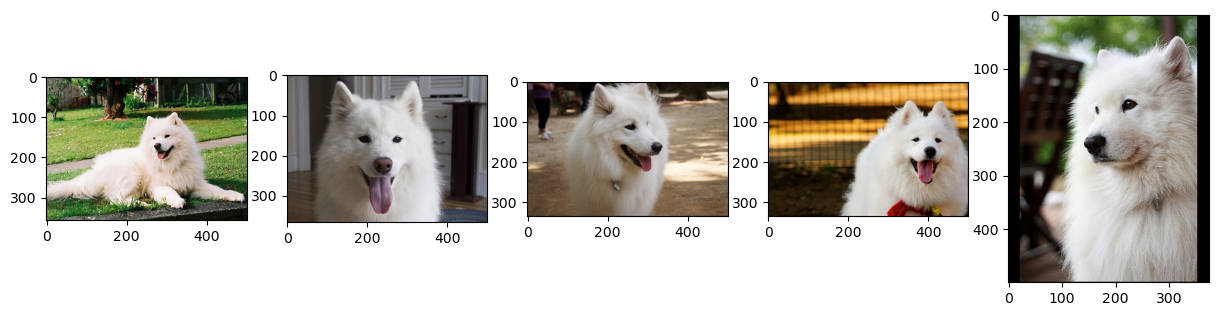

In [19]:
image_query.plot_query('a photo of white dog')

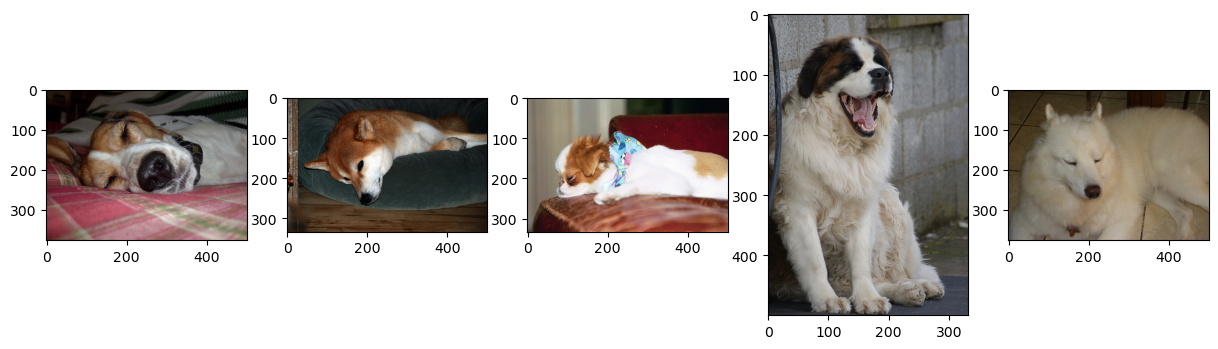

In [20]:
image_query.plot_query('a photo of a dog sleeping')

### Geração de descrições para imagens

Para quem tiver curiosidade, o código abaixo foi usado para gerar as descrições das imagens da base Oxford Pets

In [ ]:
import json
from transformers import pipeline

import sys
sys.path.insert(0, '../')
from M06_classificacao_de_imagens_naturais.dataset import OxfordIIITPet

# Cuidado, o modelo abaixo é gigante!
pipe = pipeline(model="Salesforce/blip2-opt-2.7b", task="image-to-text")
ds = OxfordIIITPet('../data/oxford_pets')
resume = True   #True=continuar de onde parou

if resume:
    results = json.load(open('../data/oxford_pets_captions.json', 'r'))
    start_idx = max(map(int, results.keys())) + 1
else:
    results = {}
    start_idx = 0

for idx in range(start_idx, len(ds)):
    if idx%10==0:
        print(idx)
    name = ds.images[idx].name
    img, _ = ds[idx]
    # Gera o caption e salva em um dicionário
    desc = pipe(img, max_new_tokens=20)[0]['generated_text'].strip()
    results[str(idx)] = [name, desc]

    json.dump(results, open('../data/oxford_pets_captions.json', 'w'))